Analyze slowing beam profile data for X-B and v10s slowers.
Data were taken by translating a photodiode in x-direction on a translation stage, and using a Thorlabs line camera.

First, here, analyze the data taken by translating the photodiode on translation stage.

In [40]:
import numpy as np
import pandas as pd

# Load spreadsheet
xl = pd.ExcelFile('Slowing Beam Profiles.xlsx')

# Load a sheet into a DataFrame by its name
df = xl.parse('Sheet1')

# Convert the DataFrame to a numeric type
df = df.apply(pd.to_numeric, errors='coerce')

# Convert the DataFrame to a numpy array
numpy_array = df.values

# Split the numpy array into two arrays, one for each column
first_column = numpy_array[:, 0]
second_column = numpy_array[:, 1]

# Split the arrays at NaN values
first_column_split = np.split(first_column, np.where(np.isnan(first_column))[0])
second_column_split = np.split(second_column, np.where(np.isnan(second_column))[0])

# Remove the arrays with NaN values
first_column_split = [a[~np.isnan(a)] for a in first_column_split if a.size > 0]
second_column_split = [a[~np.isnan(a)] for a in second_column_split if a.size > 0]

#do it twice because somehow the first time it just converts nan to empty
all_x_data = [a[~np.isnan(a)] for a in first_column_split if a.size > 0]
all_PD_data = [a[~np.isnan(a)] for a in second_column_split if a.size > 0]

# Convert all_x_data from inches to millimeters, accounting for multiplicative factor due to non-normal incidence
incidence_factor = 52.5/54.5
all_x_data_mm = [x * 25.4 * incidence_factor if i < 4 else x * 25.4 for i, x in enumerate(all_x_data)]

In [41]:
from scipy.optimize import curve_fit

# Define the Gaussian function
def gaussian(x, mean, amplitude, standard_deviation):
    return amplitude * np.exp( - ((x - mean) / standard_deviation) ** 2)

# Store the fit parameters for each set
fit_params = []

for x, y in zip(all_x_data_mm, all_PD_data):
    # Initial guess for the parameters
    initial_guess = [np.mean(x), np.max(y), np.std(x)]
    
    # Perform the curve fit
    params, params_covariance = curve_fit(gaussian, x, y, p0=initial_guess)
    
    fit_params.append(params)

# fit_params now contains the fitted parameters for each set

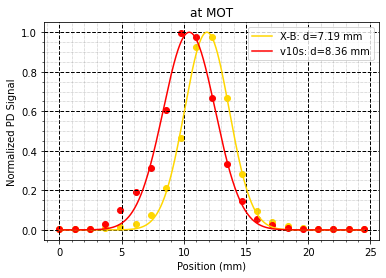

Difference in peak locations: 1.42 mm


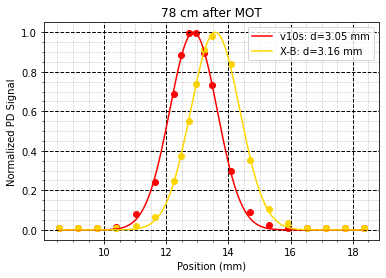

Difference in peak locations: 0.7 mm


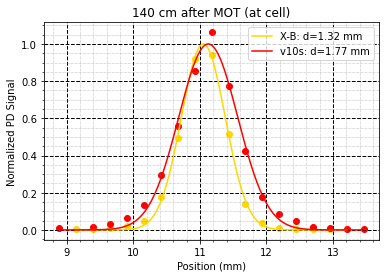

Difference in peak locations: 0.07 mm


In [52]:
import matplotlib.pyplot as plt

titles = ['at MOT', '78 cm after MOT', '140 cm after MOT (at cell)']
labels = ['X-B', 'v10s', 'v10s', 'X-B', 'X-B', 'v10s']
colors = ['gold', 'red', 'red', 'gold', 'gold', 'red']
peak_x_values = []

for i, (x, y, params) in enumerate(zip(all_x_data_mm, all_PD_data, fit_params)):
    # Only use the data points with x > 0.35 for the fourth set
    
    if i == 4:
        mask = x > 0.35*25.4  # Create a mask where each value is True if the corresponding value in x is greater than 0.35*25.4
        x = x[mask]  # Apply the mask to x
        y = y[mask]  # Apply the same mask to y

    # Generate a range of x values for the fitted function
    x_fit = np.linspace(min(x), max(x), 1000)
    
    # Compute the fitted y values
    y_fit = gaussian(x_fit, *params)

    #calculate new y-values based on normalized PD signal (to peak value)
    y = y / np.max(y_fit)
    y_fit = y_fit / np.max(y_fit)

    # Plot the original data
    plt.scatter(x, y, color=colors[i])
    
    # Plot the fitted function
    plt.plot(x_fit, y_fit, label=labels[i]+f': d={round(2 * np.sqrt(2) * np.abs(params[2]), 2)} mm', color=colors[i])
    plt.xlabel('Position (mm)')
    plt.ylabel('Normalized PD Signal')

    # Store the peak x-value (mean of the Gaussian)
    peak_x_values.append(params[0])

    if i % 2 == 1:
        plt.legend()  # Add a legend
        plt.title(titles[i//2])
        plt.grid(linestyle = '--', which = 'major', linewidth = 1, color='black')
        plt.grid(linestyle = ':', which = 'minor', linewidth = 0.5, color = 'gray')
        plt.minorticks_on()
        plt.show()
        difference = np.abs(peak_x_values[i] - peak_x_values[i-1])
        print(f'Difference in peak locations: {round(difference, 2)} mm')

Next, analyze the data taken on the Thorlabs line camera.